In [1]:
import sys
sys.path.append("../src/")
import numpy as np
import pandas as pd
from scipy.special import gamma
import utils as ut
import fBm_stats as fbms
import matplotlib.pyplot as plt
plt.style.use("plot_style.mplstyle")


data_path = "../data/fbm/"
h_s = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]

# MEAN SQUARED DISPLACEMENT

100%|██████████| 10/10 [00:00<00:00, 1855.31it/s]


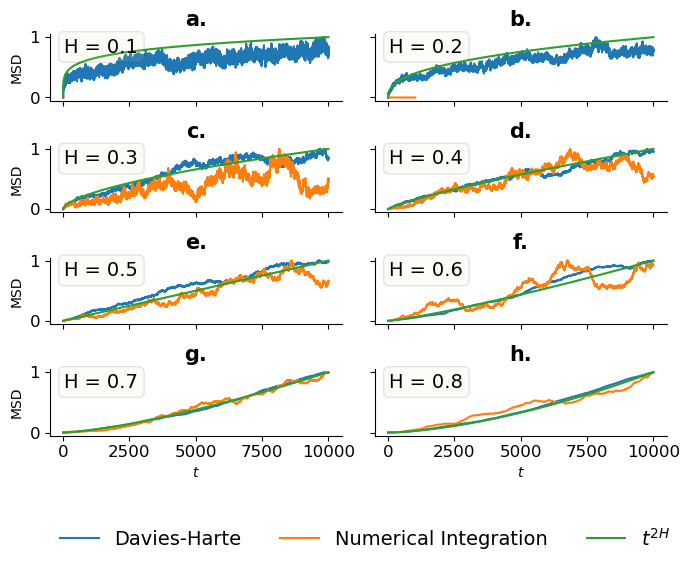

In [2]:
fig, ax = plt.subplots(int(len(h_s)/2), 2, sharex = True, sharey = True, figsize = (7,5))
col = 0
row = 0
panels = ["a.", "b.", "c.", "d.", "e.", "f.", "g.", "h."]
for i, h in enumerate(h_s):
    df_dh = ut.read_hdf5_data(data_path + f"fBm_dh-h-{h}-100.hdf5").set_index("t")
    df_in = ut.read_hdf5_all(h, data_path, 1, 10).set_index("t")
    msd_dh = fbms.msd(df_dh)
    msd_in = fbms.msd(df_in)
    
    t = df_in.index
    msd_anal = t**(2*h)
    msd_anal = msd_anal/max(msd_anal)
    
    axi = ax[row][col]

    axi.plot(t,msd_dh, label = "Davies-Harte")
    axi.plot(t,msd_in, label = "Numerical Integration")
    axi.plot(t,msd_anal, label = r"$t^{2H}$")
    axi.set_title(panels[i])
    
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.1)
    axi.text(0.05, 0.95, f"H = {h}", transform=axi.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
    
    if row == len(h_s)/2 - 1: axi.set_xlabel("$t$")

    if col == 1: row += 1; col = 0
    else: col += 1; axi.set_ylabel("MSD")


fig.tight_layout()
handles, labels = ax[0][0].get_legend_handles_labels()
fig.legend(handles, labels, bbox_to_anchor = (0.99, -0.03), ncol = len(h_s)/2);


# Normalization constant of the algorithms

## fBm trajectories

From the definition of Brownian motion we have


$$cov(B_H(t), B_H(s)) = \frac{\sigma_0^2\Gamma(2-2H)}{4H\Gamma(\frac{3}{2}-H)\Gamma(\frac{1}{2}+H)}(t^{2H}+s^{2H}-|t-s|^{2H})$$ 

$$E[B_H^2(t)] = \frac{\sigma_0^2\Gamma(2-2H)}{2H\Gamma(\frac{3}{2}-H)\Gamma(\frac{1}{2}+H)}t^{2H}$$ 



NOTES:
* The fBm algorithms implemented in python return normalized trajectories to fit:
$$E[B_H^2(t)] = t^{2H}$$ 

and 

$$cov(B_H(t), B_H(s)) = \frac{1}{2}(t^{2H}+s^{2H}-|t-s|^{2H})$$

In [3]:
def zeta(H):
    return gamma(2 - 2*H) /(4 * H * gamma(1.5 - H) * gamma(0.5 + H))

/tmp/ipykernel_27705/3503147169.py:2: RuntimeWarning: divide by zero encountered in divide
  return gamma(2 - 2*H) /(4 * H * gamma(1.5 - H) * gamma(0.5 + H))


Text(0.5, 0, 'H')

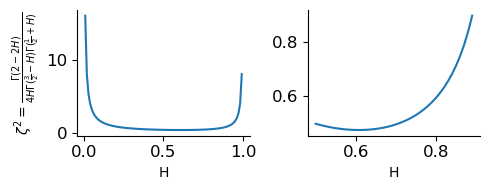

In [4]:
H = np.arange(0, 1, 0.01)
fig, ax = plt.subplots(1,2, figsize = (5, 2))
ax[0].plot(H, zeta(H))
ax[0].set_xlabel(r"H")
ax[0].set_ylabel(r"$\zeta^2 = \frac{\Gamma(2-2H)}{4H\Gamma(\frac{3}{2}-H)\Gamma(\frac{1}{2}+H)}$");

H = np.arange(0.5, 0.9, 0.01)
ax[1].plot(H, zeta(H))
ax[1].set_xlabel(r"H")

In [5]:
def get_sigma_0(H, use_zeta = True):
    
    df_dh = ut.read_hdf5_data(data_path + f"fBm_dh-h-{H}-1000.hdf5").set_index("t")
    
    mean = df_dh.mean(axis = 1)
    msd = (df_dh**2).mean(axis = 1)
    t = np.array(msd.index)
    if use_zeta:
        msd_anl = 2*zeta(H)*t**(2*H)
    else:
        msd_anl = t**(2*H)
    
    fig, ax = plt.subplots(1,3, figsize=(8,2))
    ax[0].plot(t, msd, label = "Sim.")
    ax[0].plot(t, msd_anl, label = "Anl.")
    ax[0].set_xlabel("t")
    ax[0].set_ylabel("MSD")
    ax[0].legend(loc = "upper left")

    sigma2_0 = np.mean((msd_anl/msd)[5:])

    ax[1].plot(t, msd_anl/msd)
    ax[1].axhline(y = sigma2_0, color = "red")
    ax[1].set_xlabel("t")
    ax[1].set_ylabel("Scale factor")

    ax[2].hist(msd_anl/msd, orientation="horizontal")
    ax[2].axhline(y = sigma2_0, color = "red")
    ax[2].set_ylabel("Freq.")
    ax[2].set_xlabel("Dist. Scale factor")
    
    fig.suptitle("H = " + str(H))
    
    return pd.DataFrame({"H":[H], "sigma2_0": [sigma2_0]})

,H,sigma2_0
0,0.1,0.988378
1,0.2,1.005252
2,0.3,1.060743
3,0.4,0.959002
4,0.5,0.962532
5,0.6,0.936747
6,0.7,0.983906
7,0.8,1.034250
8,0.9,1.020265


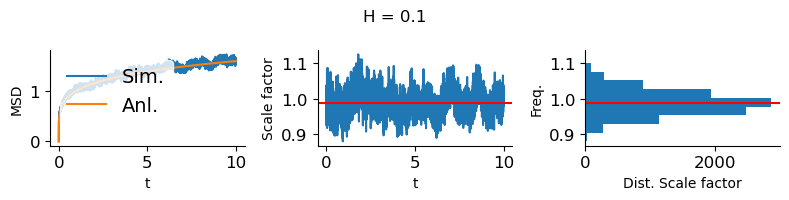

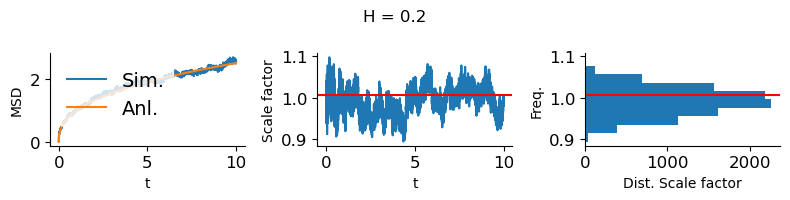

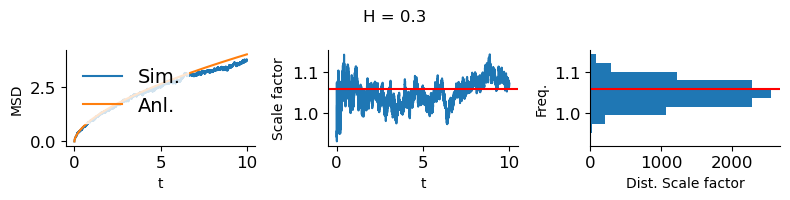

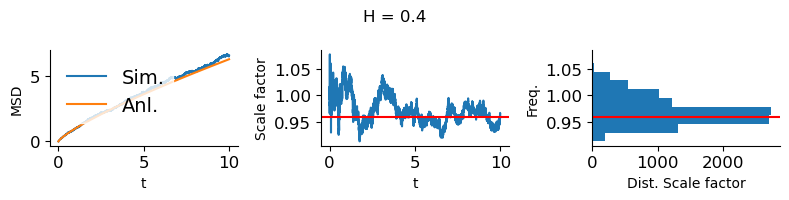

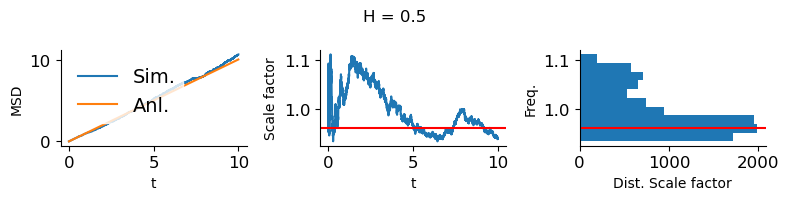

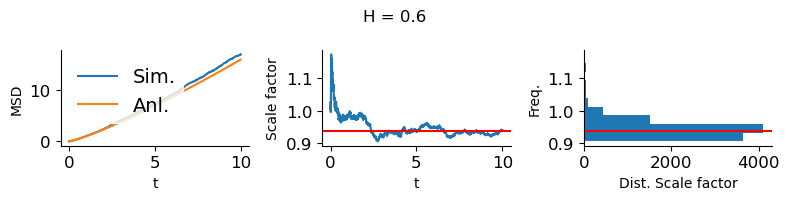

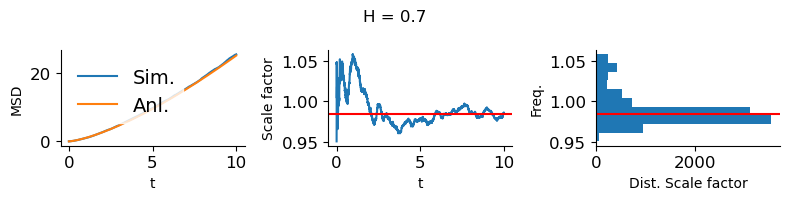

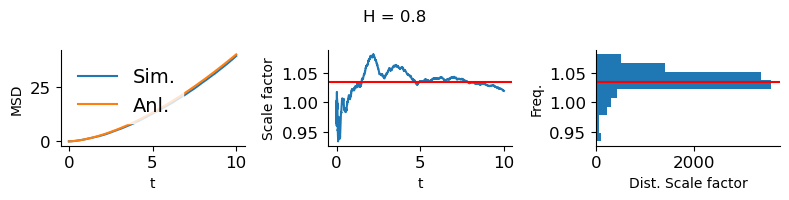

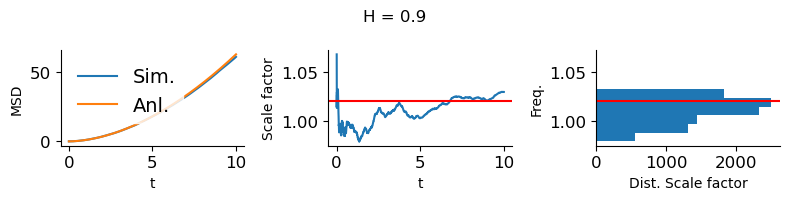

In [6]:
df = pd.DataFrame()
df = pd.concat([df,get_sigma_0(0.1, use_zeta = False)])
df = pd.concat([df,get_sigma_0(0.2, use_zeta = False)])
df = pd.concat([df,get_sigma_0(0.3, use_zeta = False)])
df = pd.concat([df,get_sigma_0(0.4, use_zeta = False)])
df = pd.concat([df,get_sigma_0(0.5, use_zeta = False)])
df = pd.concat([df,get_sigma_0(0.6, use_zeta = False)])
df = pd.concat([df,get_sigma_0(0.7, use_zeta = False)])
df = pd.concat([df,get_sigma_0(0.8, use_zeta = False)])
df = pd.concat([df,get_sigma_0(0.9, use_zeta = False)])
df.reset_index(drop = True, inplace = True)
df

# (AUTO)COVARIANCE

In [7]:
def cov_fBm(t, t_ref, H):
    return 0.5*(t**(2*H) + t_ref**(2*H) - np.abs(t-t_ref)**(2*H))

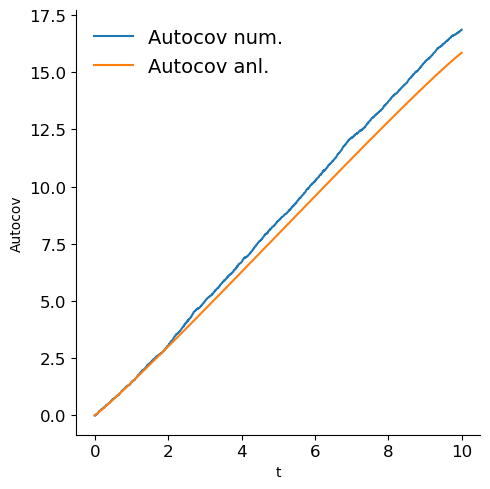

In [9]:
t_ref = 10

H=0.6

series = ut.read_hdf5_data(data_path + f"fBm_dh-h-{H}-1000.hdf5").set_index("t")

autocov = fbms.cov(series, t_ref)
t = autocov.index

fig, ax = plt.subplots(figsize=(5,5))
ax.plot(t, autocov, label = "Autocov num.")
ax.plot(t, cov_fBm(t, t_ref, H), label = "Autocov anl.")
ax.set_xlabel("t")
ax.set_ylabel("Autocov")
ax.legend(loc = "upper left")


## fractional Gaussian Noise

Similarly, the covariance and expected value of the fGn $\xi_H = \frac{d B_H (t)}{dt}$ are given by:


$$\frac{\partial^2}{\partial t \partial s} cov(\xi_H(t), \xi_H(s)) = cov(\xi_H(t), \xi_H(s)) = \frac{\sigma_0^2(2H-1)\Gamma(2-2H)}{2\Gamma(\frac{3}{2}-H)\Gamma(\frac{1}{2}+H)}|t-s|^{2H-2}$$ 



NOTES:
* In the fBm algorithms $V = 1$ thus, the covariance must fit 

$$ cov(\xi_H(t), \xi_H(s)) = 2H(2H-1)|t-s|^{2H-2}$$ 

TODO: noise covariance and scaling factor